# Classic autoencoder architectures

Based off of this [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) from the Keras blog.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA

## Load MNIST digits dataset

We are going to normalize the 28 x 28 grayscale values from $0\ldots255$ to $[0, 1]$ and flatten them into 784-element arrays.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert uint8 grayscale pixels [0, 255] to floats in [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the 28 x 28 grayscale images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


interactive(children=(IntSlider(value=0, description='i', max=59999), Output()), _dom_classes=('widget-interac…

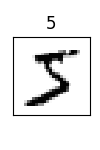

In [4]:
plt.figure(figsize=(1, 1.5))
ax = plt.subplot(111)
ax.set_aspect(1)

@interact(i=(0, x_train.shape[0] - 1))
def show_digit(i=0):
    ax.matshow(x_train[i].reshape(28, 28), cmap='Greys', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[i])

Some helper functions for plotting.

In [5]:
def plot_scatter(ax, x1, x2, labels, xlabel='z1', ylabel='z2'):
    ax.axhline(0, c='k', lw=0.5, ls='--')
    ax.axvline(0, c='k', lw=0.5, ls='--')
    h = ax.scatter(
        x1, 
        x2,
        c=labels, 
        s=5,
        edgecolor='none', 
        alpha=0.5,
        cmap=plt.cm.get_cmap('nipy_spectral', 10),
    )
    ax.set_aspect(1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(h, ticks=np.arange(0, 10), values=np.arange(0, 10));
    

def plot_reconstruction(ax, x_test, encoded, reconstructed, code_reshape, n):
    gs = plt.GridSpec(3, n)
    
    for i in range(n):
        # Display original
        ax = plt.subplot(gs[0, i])
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        if i == 0:
            plt.ylabel("Original")

        # Display encoding
        ax = plt.subplot(gs[1, i])
        if isinstance(code_reshape, int):
            code = [encoded[i]]
        else:
            code = encoded[i].reshape(code_reshape)
        vopt = np.max(np.abs(code))
        plt.imshow(code, cmap='RdBu_r', vmin=-vopt, vmax=vopt)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        if i == 0:
            plt.ylabel("Code")
            
        # Display reconstruction
        ax = plt.subplot(gs[2, i])
        plt.imshow(reconstructed[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        if i == 0:
            plt.ylabel("Reconstruction")
    

## PCA

### Training and encoding

Before we jump into autoencoders, let's revisit PCA using scikit-learn's estimator.

We're going to perform a 2-component PCA, fitting the model to the training data. Instead of calculating projections of the data we trained on, this time we'll use the `transform` method to project the left-out **test data** digits onto the first two PC vectors.

The "encoder" function for PCA to transform a single input $x$ (after subtracting the feature-wise mean calculated from the training data) is

$$ z = f(x) = \hat{V} x, $$

where the columns of $V$ are the first 2 PC loading vectors we calculated.

In [6]:
pca = PCA(n_components=2)
pca.fit(x_train)
projected = pca.transform(x_test)

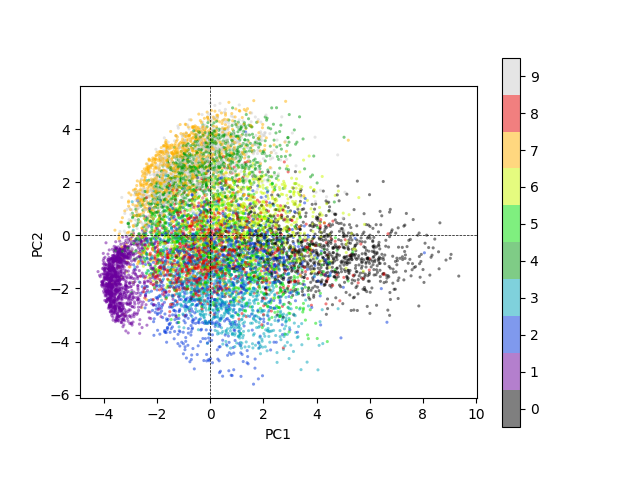

In [7]:
plt.figure()
ax = plt.subplot(111)
plot_scatter(ax, projected[:, 0], projected[:, 1], y_test, xlabel='PC1', ylabel='PC2')

### Reconstruction and decoding

Now we are going to send our 2D projections back to the original coordinate system by reversing the projection with the `inverse_transform` method. Remember that the complete matrix of all PCs $V$ is orthogonal, so its inverse is $V^T$. If we were to use all PCs, we would get back a perfect reconstruction by applying $V^T$. Since we are only using the first two PCs in $\hat{V}$, the reconstruction $\hat{x}$ of a transformed input $x$ will be lossy.

$$ \hat{x} = g(z) = \hat{V}^T z = \hat{V}^T \hat{V} x \approx x $$

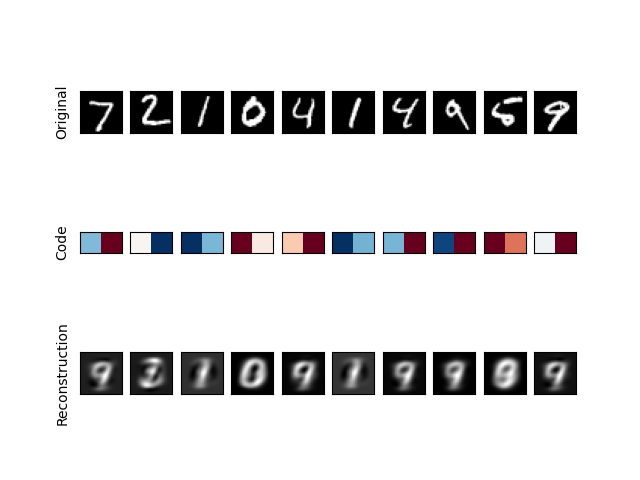

In [8]:
plt.figure()
ax = plt.subplot(111)

projected = pca.transform(x_test)
reconstructed = pca.inverse_transform(projected)
plot_reconstruction(ax, x_test, projected, reconstructed, (1, 2), n=10)

## Linear autoencoder with least squares loss

This exercise will empirically validate that a linear autoencoder (i.e., one that does not use a non-linear activation function) trained with mean-squared error reconstruction loss and a bottleneck of $k$ hidden units will learn the exact same linear subspace as a $k$-component PCA.

That is, the matrix of weights of the encoder and that of the decoder will transform the data to and from the same subspace spanned by the first $k$ PCs, respectively.

In [9]:
latent_dim = 2

# input placeholder
input_img = tf.keras.Input(shape=(784,))

# the encoded representation of the input
encoded = layers.Dense(latent_dim, activation='linear')(input_img)

# the reconstruction of the input
decoded = layers.Dense(784, activation='linear')(encoded)

# maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# encoder: maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# decoder: maps encoded representation to its reconstruction
input_encoded = tf.keras.Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.Model(input_encoded, decoder_layer(input_encoded))

2022-11-10 10:17:41.238297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


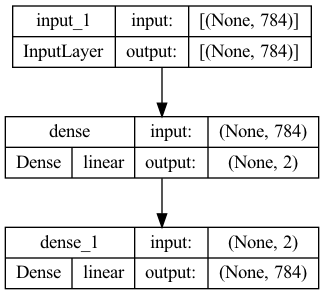

In [10]:
plot_model(autoencoder, show_shapes=True, show_layer_activations=True)

In [11]:
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0683 - val_loss: 0.0584
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0576
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0575
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0574
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0574
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0573
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0573
Epoch 8/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0572
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0572
Epoch 10/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.0571

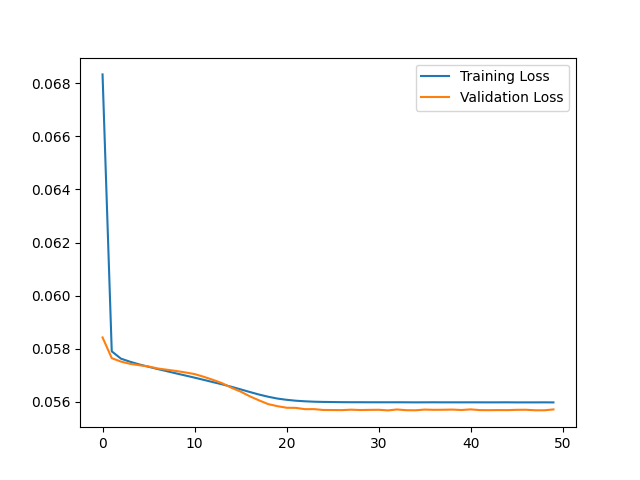

In [12]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

313/313 [==============================] - 0s 357us/step


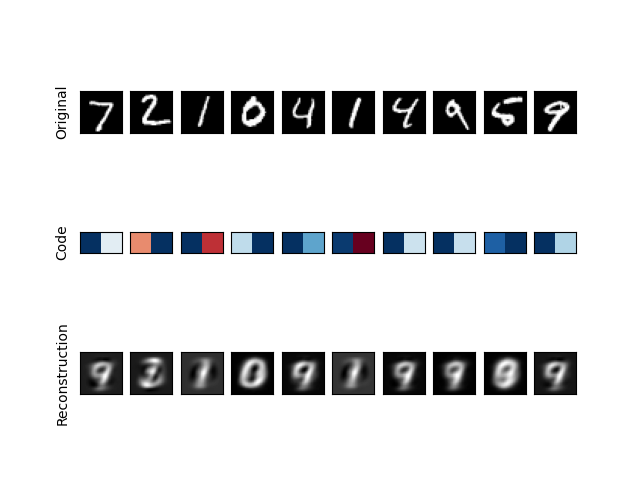

In [13]:
plt.figure()
ax = plt.subplot(111)
x_test_encoded = encoder.predict(x_test)
x_test_decoded = decoder.predict(x_test_encoded)
plot_reconstruction(ax, x_test, x_test_encoded, x_test_decoded, (1, 2), n=10)

You will probably see that the projection from the linear autoencoder is warped and/or rotated relative to the PC projection. That is because the vectors the encoder learns are only optimized to span the same subspace as the PCs -- they need not individually align with the directions of greatest variance or be orthogonal to each other.

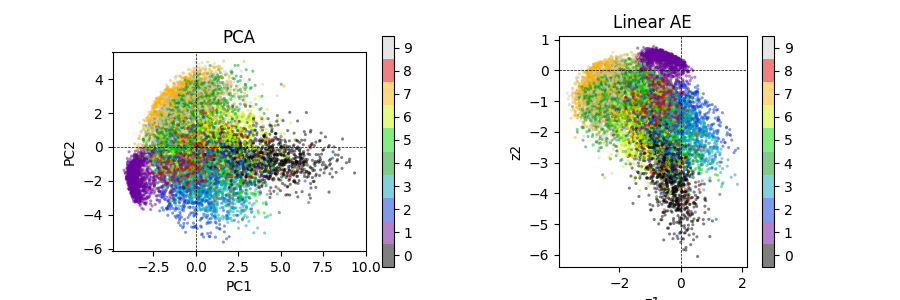

In [14]:
plt.figure(figsize=(9, 3))
gs = plt.GridSpec(nrows=1, ncols=2)

ax = plt.subplot(gs[0])
plot_scatter(ax, projected[:, 0], projected[:, 1], y_test, xlabel='PC1', ylabel='PC2')
ax.set_title('PCA')

ax = plt.subplot(gs[1])
plot_scatter(ax, x_test_encoded[:, 0], x_test_encoded[:, 1], y_test, xlabel='z1', ylabel='z2')
ax.set_title('Linear AE');

## Undercomplete autoencoder

Now let's try using non-linear activation functions with a bottleneck.

We use `ReLu` for the encoder activation. We use `sigmoid` for the decoder activation, so rescale the output values to `[0, 1]` just like our input.

In [15]:
latent_dim = 2

# input placeholder
input_img = tf.keras.Input(shape=(784,))

# the encoded representation of the input
encoded = layers.Dense(latent_dim, activation='relu')(input_img)

# the reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)  # Sigmoid stretches/squishes output to [0, 1]

# maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# encoder: maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# decoder: maps encoded representation to its reconstruction
input_encoded = tf.keras.Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.Model(input_encoded, decoder_layer(input_encoded))

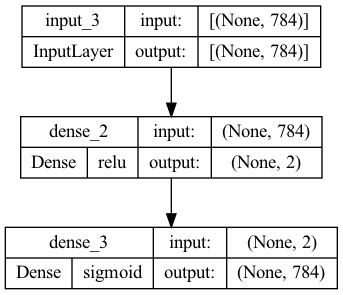

In [16]:
plot_model(autoencoder, show_shapes=True, show_layer_activations=True)

In [17]:
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1083 - val_loss: 0.0719
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0687
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0646
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0629
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0619
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0612
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0605
Epoch 8/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0598
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0593
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0588

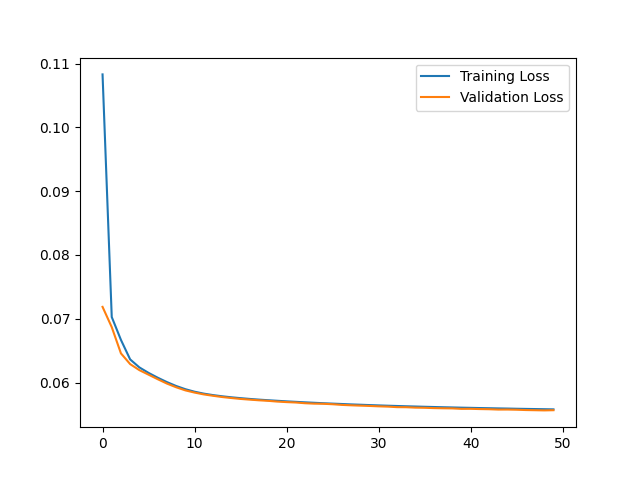

In [18]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

313/313 [==============================] - 0s 426us/step


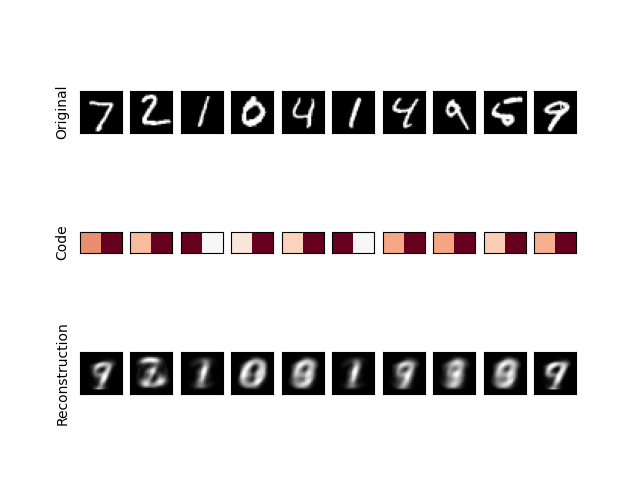

In [19]:
plt.figure()
ax = plt.subplot(111)
x_test_encoded = encoder.predict(x_test)
x_test_decoded = decoder.predict(x_test_encoded)
plot_reconstruction(ax, x_test, x_test_encoded, x_test_decoded, (1, 2), n=10)

## More layers

Now, let's try adding a few more hidden layers of decreasing width to both the encoder and decoder.

In [20]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

encoded = layers.Dense(2, activation='relu')(encoded)

decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [21]:
# maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# encoder: maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# decoder: maps encoded representation to its reconstruction
input_encoded = tf.keras.Input(shape=(2,))
decoder_layers = tf.keras.Sequential(autoencoder.layers[-4:])
decoder = tf.keras.Model(input_encoded, decoder_layers(input_encoded))

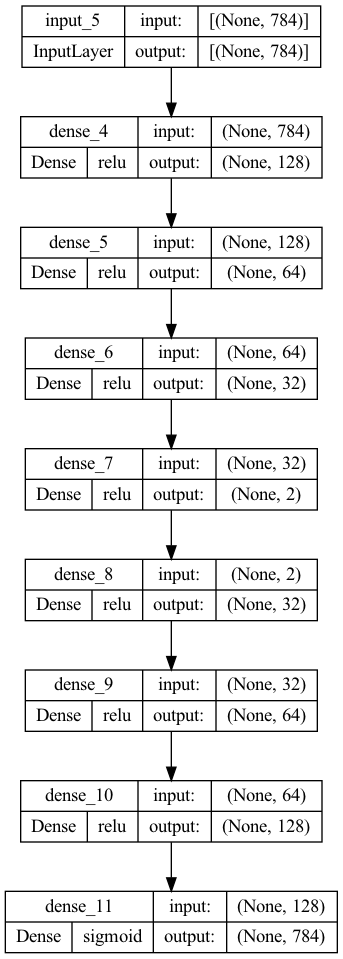

In [22]:
autoencoder.compile(optimizer='adam', loss='mse')
plot_model(autoencoder, show_shapes=True, show_layer_activations=True)

In [23]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
 dense_8 (Dense)             (None, 32)                96        
                                                                 
 dense_9 (Dense)             (None, 64)                2112

In [24]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 2s 6ms/step - loss: 0.0786 - val_loss: 0.0647
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0632 - val_loss: 0.0624
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0615 - val_loss: 0.0608
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0593 - val_loss: 0.0580
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0573 - val_loss: 0.0565
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0517 - val_loss: 0.0480
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0464 - val_loss: 0.0454
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0444 - val_loss: 0.0437
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0433 - val_loss: 0.0428
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0425 - val_lo

313/313 [==============================] - 0s 605us/step


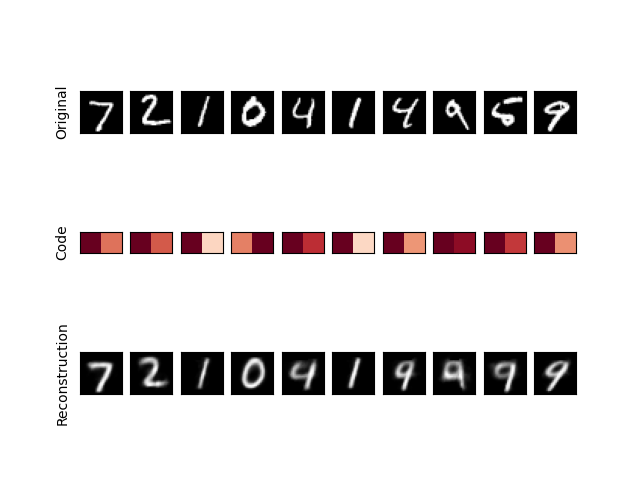

In [25]:
plt.figure()
ax = plt.subplot(111)
x_test_encoded = encoder.predict(x_test)
x_test_decoded = decoder.predict(x_test_encoded)
plot_reconstruction(ax, x_test, x_test_encoded, x_test_decoded, (1, 2), n=10)

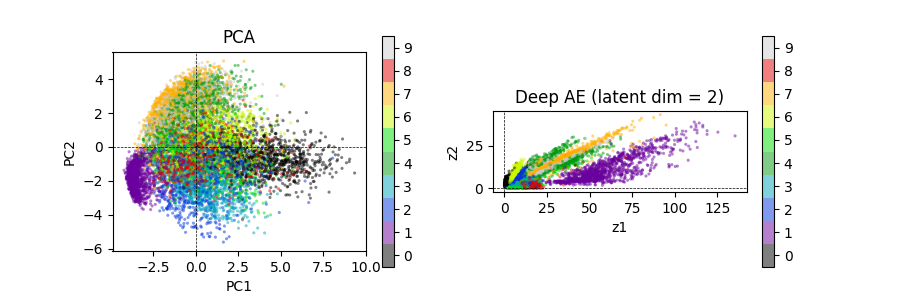

In [26]:
plt.figure(figsize=(9, 3))
gs = plt.GridSpec(nrows=1, ncols=2)

ax = plt.subplot(gs[0])
plot_scatter(ax, projected[:, 0], projected[:, 1], y_test, xlabel='PC1', ylabel='PC2')
ax.set_title('PCA')

ax = plt.subplot(gs[1])
plot_scatter(ax, x_test_encoded[:, 0], x_test_encoded[:, 1], y_test, xlabel='z1', ylabel='z2')
ax.set_title('Deep AE (latent dim = 2)');

## Sparse autoencoder

In order to make a sparse autoencoder, we need to apply a special regularization penality to the activations of our hidden layer. This is different from a penalty on the weights, which would typically go into the loss function. 

Instead, keras provides a `activity_regularizer` parameter during layer construction to which we can pass an L1 regularizer instance.

In [27]:
from keras import regularizers
from keras.regularizers import l1

latent_dim = 32

input_img = keras.Input(shape=(784,))

# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(
    latent_dim, 
    activation='relu',
    activity_regularizer=l1(0.001)
)(input_img)

decoded = layers.Dense(784, activation='sigmoid')(encoded)

# maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)

# encoder: maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# decoder: maps encoded representation to its reconstruction
input_encoded = tf.keras.Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.Model(input_encoded, decoder_layer(input_encoded))

In [28]:
autoencoder.compile(optimizer='adam', loss='mse')

# encoder: maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# decoder: maps encoded representation to its reconstruction
input_encoded = tf.keras.Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.Model(input_encoded, decoder_layer(input_encoded))

history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1148 - val_loss: 0.0710
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0616 - val_loss: 0.0558
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0533 - val_loss: 0.0506
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0492 - val_loss: 0.0474
Epoch 5/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0464 - val_loss: 0.0451
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0443 - val_loss: 0.0432
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0426 - val_loss: 0.0417
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0413 - val_loss: 0.0405
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0402 - val_loss: 0.0394
Epoch 10/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0393 - val_loss: 0.0386

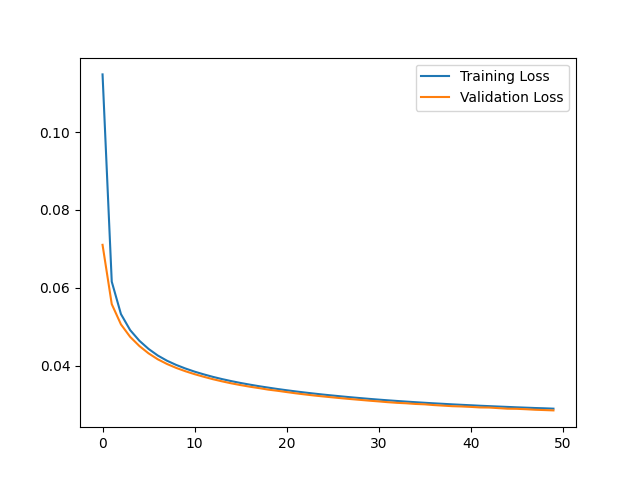

In [29]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Compare to the simple undercomplete autoencoder using the same bottleneck size and you'll see that the latent encodings here sparser.

313/313 [==============================] - 0s 452us/step


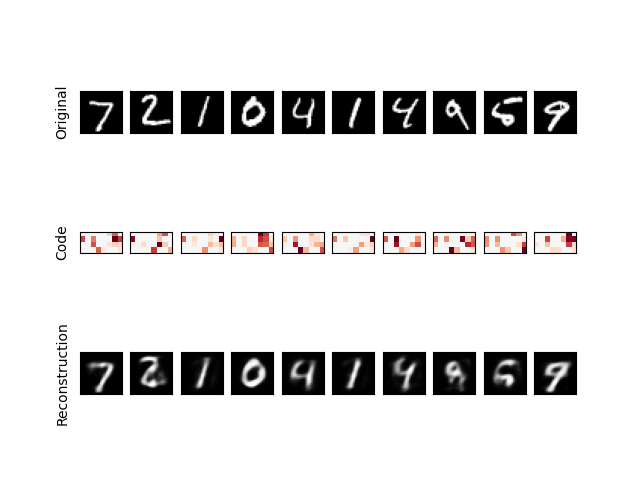

In [30]:
plt.figure()
ax = plt.subplot(111)
x_test_encoded = encoder.predict(x_test)
x_test_decoded = decoder.predict(x_test_encoded)
plot_reconstruction(ax, x_test, x_test_encoded, x_test_decoded, (4, 8), n=10)

## Denoising autoencoder

Now, we'll construct a denoising autoencoder by first corrupting our training and test data with some Gaussian noise.

In [31]:
from keras.datasets import mnist
import numpy as np

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

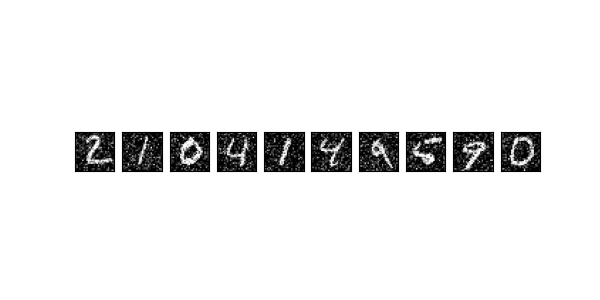

In [32]:
n = 10
plt.figure(figsize=(6, 3))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

The only change we need to apply is that we pass the noisy input `x_train_noisy` as input against the clean data `x_train` as output for training. Similarly, we pass the corrupted and clean test data as input and output for validation.

In [33]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# encoder: maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)

# decoder: maps encoded representation to its reconstruction
input_encoded = tf.keras.Input(shape=(32,))
decoder_layers = tf.keras.Sequential(autoencoder.layers[-3:])
decoder = tf.keras.Model(input_encoded, decoder_layers(input_encoded))

In [34]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 0.0667 - val_loss: 0.0417
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0361 - val_loss: 0.0319
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0299 - val_loss: 0.0274
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0262 - val_loss: 0.0244
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0238 - val_loss: 0.0227
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0215 - val_loss: 0.0208
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0206 - val_loss: 0.0197
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0196 - val_loss: 0.0189
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0189 - val_loss: 0.0183

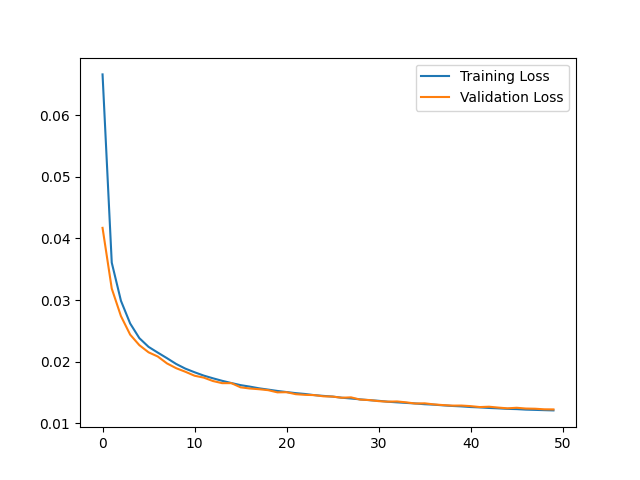

In [35]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Now, we'll pass the corrupted test data through both encoder and decoder to attempt to remove the noise.

313/313 [==============================] - 0s 596us/step


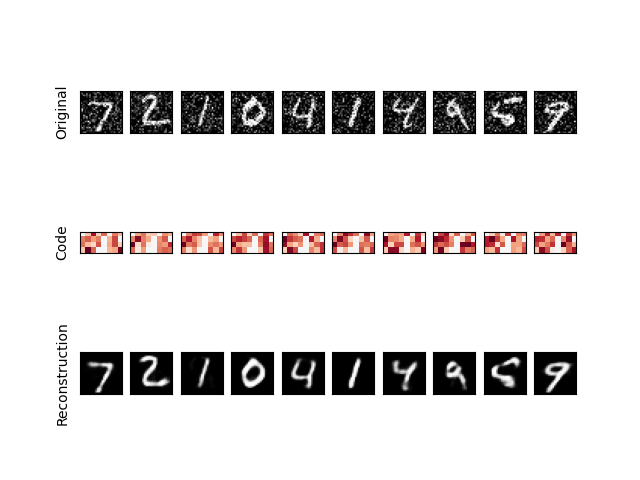

In [36]:
plt.figure()
ax = plt.subplot(111)
x_test_encoded = encoder.predict(x_test_noisy)
x_test_decoded = decoder.predict(x_test_encoded)
plot_reconstruction(ax, x_test_noisy, x_test_encoded, x_test_decoded, (4, 8), n=10)